# Day 1 ATIS-2025 Workshop

## Part A - Building & Visualizing Single and Multi Qubit Circuits

### Import Libraries

In [1]:
import math
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_vector
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.visualization import plot_circuit_layout
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import depolarizing_error



### Create a Quantum Circuits

In [ ]:
x = [0.1, 0.2, 0.3]  # Example classical data points

qc = QuantumCircuit(3, 3)  # Create a quantum circuit with 3 qubits and 3 classical bits

# angle encoding using Ry rotations
qc.ry(x[0], 0)  # Apply Ry rotation on qubit 0
qc.ry(x[1], 1)  # Apply Ry rotation on qubit 1
qc.ry(x[2], 2)  # Apply Ry rotation on qubit 2

# entangling the qubits
qc.cx(0, 1)  # Apply CNOT gate with qubit 0 as control and qubit 1 as target
qc.cx(1, 2)  # Apply CNOT gate with qubit 1 as control and qubit 2 as target
qc.cx(2, 0)  # Apply CNOT gate with qubit 2 as control and qubit 0 as target

qc.measure([0, 1, 2], [0, 1, 2])  # Measure qubits into classical bits

### Visualise circuit

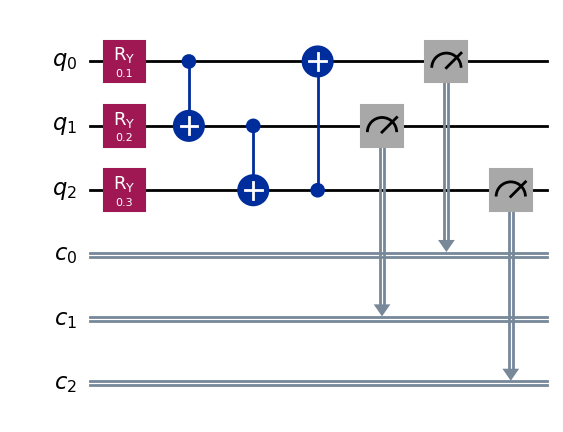

In [29]:
qc.draw('mpl', cregbundle=False)


### Visualise transpiled circuit on FakeManilaV2 backend

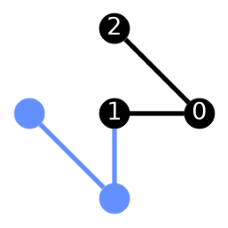

In [30]:
backend = FakeManilaV2() 
transpiled_qc = transpile(qc, backend=backend)  # Transpile the circuit
plot_circuit_layout(transpiled_qc, backend=backend)  # Visualise transpiled circuit layout

### Visualise the Bloch Sphere representation of a qubit after a rotation

$$ R_y(\theta) = \begin{bmatrix}
\cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \\
\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right)
\end{bmatrix}

\rightarrow

R_y\!\left(\frac{\pi}{4}\right) = \begin{bmatrix}
\cos\left(\frac{\pi}{8}\right) & -\sin\left(\frac{\pi}{8}\right) \\
\sin\left(\frac{\pi}{8}\right) & \cos\left(\frac{\pi}{8}\right)
\end{bmatrix} $$

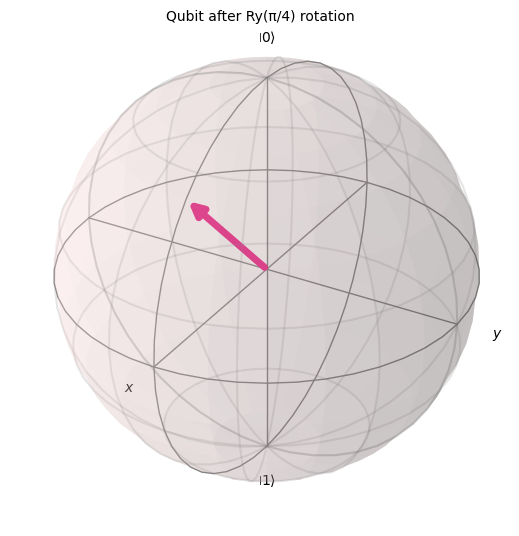

In [31]:
bloch_vector = [math.sin(math.pi / 4), 0, math.cos(math.pi / 4)]
plot_bloch_vector(bloch_vector, title="Qubit after Ry(π/4) rotation")

## Part B — Creating Bell State


Two qubits starting in state 0, entangled via a Hadamard gate and a CNOT gate. After being measured, the two qubits will either be in state 00 or 11 with equal probability. We can represent this mathematically as:

$$|\beta_{00}\rangle = \frac{1}{\sqrt{2}}\bigl(|00\rangle + |11\rangle\bigr) $$

### Create Bell State Circuit

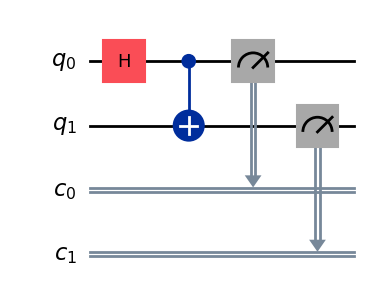

In [19]:
bell_qc = QuantumCircuit(2, 2)  # Create a quantum circuit with 2 qubits and 2 classical bits
bell_qc.h(0)  # Apply Hadamard gate on qubit 0
bell_qc.cx(0, 1)  # Apply CNOT gate with qubit 0 as control and qubit 1 as target
bell_qc.measure([0, 1], [0, 1])  # Measure qubits into classical bits
bell_qc.draw('mpl', cregbundle=False)

### Run Bell State Circuit on Simulator and Visualise Results

Text(0.5, 0.98, 'Bell State Measurement Results (4 runs)')

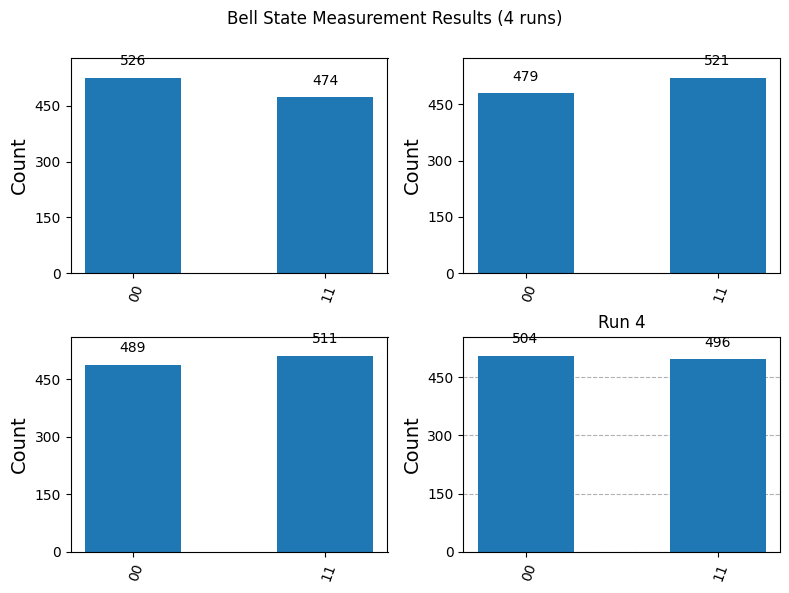

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for i in range(4):
    simulator = AerSimulator()  # Use Aer's simulator
    circ = transpile(bell_qc, backend=simulator)  # Transpile the circuit for the simulator
    result = simulator.run(circ, shots=1000).result()  # Execute the circuit on the simulator
    counts = result.get_counts(bell_qc)  # Get the measurement results
    plot_histogram(counts, ax=axes[i], title=f"Run {i+1}")

plt.tight_layout()
plt.subplots_adjust(top=0.90)
fig.suptitle("Bell State Measurement Results (4 runs)")


## Part C — Build a depolarizing noise model


### Create Bell State Circuit with measurements

In [4]:
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

### Create Noise Models & Simulate Circuit under Noise Conditions

In [11]:
noise_model = NoiseModel()

single_qubit_errors = [0.01, 0.1 ]  # Example error rates for single-qubit gates
two_qubit_errors = [0.02, 0.1 ]     # Example error rates for two-qubit gates
number_of_shots = [50, 100, 500 ]        # Example number of shots for simulation

for shots in number_of_shots:
    for s_err in single_qubit_errors:
        for t_err in two_qubit_errors:
            nm = NoiseModel() # Create a new noise model for each configuration
            nm.add_all_qubit_quantum_error(depolarizing_error(s_err, 1), ['h']) # Add single-qubit depolarizing error to Hadamard gates
            nm.add_all_qubit_quantum_error(depolarizing_error(t_err, 2), ['cx']) # Add two-qubit depolarizing error to CNOT gates

            simulator = AerSimulator(noise_model=nm) # Create simulator with the noise model
            transpiled_qc = transpile(qc, backend=simulator) # Transpile the circuit for the simulator
            result = simulator.run(transpiled_qc, shots=shots).result() # Execute the circuit
            counts = result.get_counts(qc) # Get the measurement results
            ideal_counts = {'00': shots / 2, '11': shots / 2} # Ideal counts for Bell state
            fidelity = sum(min(counts.get(state, 0), ideal_counts[state]) for state in ideal_counts) / shots # Calculate fidelity
            print(f"Shots: {shots}, Single-Qubit Error: {s_err}, Two-Qubit Error: {t_err}, Fidelity: {fidelity:.4f}") 



Shots: 50, Single-Qubit Error: 0.01, Two-Qubit Error: 0.02, Fidelity: 1.0000
Shots: 50, Single-Qubit Error: 0.01, Two-Qubit Error: 0.1, Fidelity: 0.9200
Shots: 50, Single-Qubit Error: 0.1, Two-Qubit Error: 0.02, Fidelity: 0.9800
Shots: 50, Single-Qubit Error: 0.1, Two-Qubit Error: 0.1, Fidelity: 0.8800
Shots: 100, Single-Qubit Error: 0.01, Two-Qubit Error: 0.02, Fidelity: 0.9400
Shots: 100, Single-Qubit Error: 0.01, Two-Qubit Error: 0.1, Fidelity: 0.9600
Shots: 100, Single-Qubit Error: 0.1, Two-Qubit Error: 0.02, Fidelity: 0.9900
Shots: 100, Single-Qubit Error: 0.1, Two-Qubit Error: 0.1, Fidelity: 0.8700
Shots: 500, Single-Qubit Error: 0.01, Two-Qubit Error: 0.02, Fidelity: 0.9820
Shots: 500, Single-Qubit Error: 0.01, Two-Qubit Error: 0.1, Fidelity: 0.9680
Shots: 500, Single-Qubit Error: 0.1, Two-Qubit Error: 0.02, Fidelity: 0.9900
Shots: 500, Single-Qubit Error: 0.1, Two-Qubit Error: 0.1, Fidelity: 0.9460
